In [1]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from itertools import zip_longest
from typing import Set, List
import requests
import logging
import csv
from retry import retry
import os
import json
import time


In [2]:
REDDIT_API_URL = 'https://api.pushshift.io/reddit'
REDDIT_SEARCH_COMMENT_ENDPOINT = '/comment/search'
REDDIT_SEARCH_COMMENT_URL = f'{REDDIT_API_URL}{REDDIT_SEARCH_COMMENT_ENDPOINT}'
DESIRED_AUTHORS_AMOUNT = 1000
AUTHORS_CSV_FILE_NAME = 'subreddit_authors.csv'
SUBREDDITS_INTERSECTIONS_CSV_NAME = 'subreddits_intersections.csv'
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
subreddits_names = ['r/classicalmusic', "r/opera", "r/ambientmusic", "r/chillout", "r/deephouse", "r/DnB", "r/dubstep",
                    "r/EDM", "r/electronicdancemusic", "r/rock", "r/indieheads", "r/electronicmusic", "r/blues", "r/folk",
                    "r/Metal", "r/punk", "r/hiphopheads", "r/hiphop101", "r/rap", "r/Jazz", "r/reggae"]


In [6]:
def list_subreddit_authors(subreddit_name: str, limit: int = DESIRED_AUTHORS_AMOUNT) -> Set[str]:
    logger.info(
        f'Fetching <{limit}> subreddit_authors from <{subreddit_name}> subreddit')
    authors_set = set()
    params = {
        'subreddit': subreddit_name,
        'size': 1000,
        'fields': 'author'
    }
    index_base = 0
    index = 0
    while len(authors_set) < limit:
        logger.debug(
            f'Fetching the bulk that starts with the <{index_base+index}> author')
        index_base += index
        response = requests.get(REDDIT_SEARCH_COMMENT_URL, params=params)
        data = response.json()
        if not data['data']:
            break
        for index, comment in enumerate(data.get('data')):
            authors_set.add(comment.get('author'))
        params['before'] = data.get('data')[-1].get('created_utc')
        logger.debug('Still working...')
    logger.info(
        f'Done fetching <{limit}> subreddit_authors from <{subreddit_name}> subreddit')
    return authors_set


In [ ]:
authors_by_subreddit: List[Set[str]] = []
for subreddit in subreddits_names:
    subreddit_authors = list_subreddit_authors(subreddit)
    authors_by_subreddit.append(subreddit_authors)


In [6]:
def write_subreddits_authors_to_csv(values: Set[str], labels: List[str]) -> None:
    logger.info(
        f'Writing authors names of comments in <{len(values)}> subreddits to file: <{AUTHORS_CSV_FILE_NAME}>')
    with open(AUTHORS_CSV_FILE_NAME, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
        for row in zip_longest(*values, fillvalue=''):
            writer.writerow(row)
    logger.info('Done writing to CSV file')


In [7]:
def plot_and_save_venn_diagram(authors_by_subreddit: list, labels: List[str]):
    venn3(authors_by_subreddit[:3], set_labels=(labels))
    logger.info(
        'Plotting 1 exapmple venn diagram to demonstrated example intersection between subreddits')
    plt.savefig('venn_diagram.png')


In [8]:
def write_authors_intersections_to_csv(authors_by_subreddit: list, labels: List[str]):
    intersections = []
    intersections_labels = []

    logger.info('Calgulating intersections between subreddits...')
    for i in range(len(authors_by_subreddit)):
        for j in range(i+1, len(authors_by_subreddit)):
            intersections.append(
                authors_by_subreddit[i].intersection(authors_by_subreddit[j]))
            intersections_labels.append(f'{labels[i]} & {labels[j]}')
            logger.debug(
                f"{labels[i]} & {labels[j]} {authors_by_subreddit[i].intersection(authors_by_subreddit[j])}")

    with open(SUBREDDITS_INTERSECTIONS_CSV_NAME, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(intersections_labels)
        for row in zip_longest(*intersections, fillvalue=''):
            writer.writerow(row)
    logger.info(
        f'All intersections between subreddits were persisted as CSV file called <{SUBREDDITS_INTERSECTIONS_CSV_NAME}>')


write_authors_intersections_to_csv(authors_by_subreddit, subreddits_names)


INFO:__main__:Calgulating intersections between subreddits...
INFO:__main__:All intersections between subreddits were persisted as CSV file called <subreddits_intersections.csv>


INFO:__main__:Writing authors names of comments in <21> subreddits to file: <subreddit_authors.csv>
INFO:__main__:Done writing to CSV file
INFO:__main__:Plotting 1 exapmple venn diagram to demonstrated example intersection between subreddits


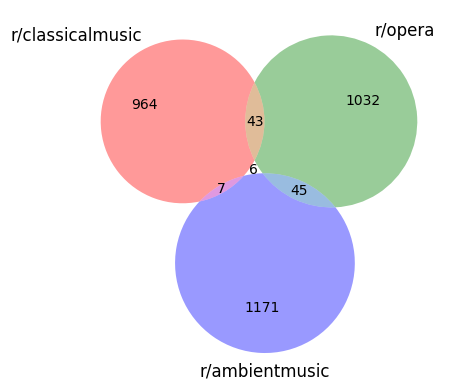

In [9]:
write_subreddits_authors_to_csv(authors_by_subreddit, subreddits_names)
plot_and_save_venn_diagram(authors_by_subreddit, subreddits_names)


# Diving Deeper

### Picking up 5 relatively distinct large musical genres communities and extract latest 1M comments and their authors


In [8]:
# Definitions
distinct_large_communities = [
    'r/indieheads', 'r/electronicmusic', 'r/hiphopheads', 'r/Metal', 'r/classicalmusic']
days_window = 1
comment_url = "https://api.pushshift.io/reddit/comment/search/"
submission_url = "https://api.pushshift.io/reddit/submission/search/"
blacklisted_users = ['[deleted]', 'AutoModerator']


In [9]:
@retry((requests.exceptions.RequestException, requests.exceptions.Timeout, requests.exceptions.HTTPError, requests.exceptions.ConnectionError, requests.exceptions.JSONDecodeError), delay=5, tries=5)
def throttle_get_request(url, params):
    try:
        response = requests.get(url, params=params)
        data = response.json().get("data", [])
        return data
    except Exception as e:
        logger.warning(
            f"handling bad response. response's status: {response.status_code}")
        raise e


In [10]:
def write_list_to_json_file(data_list, file_path):
    file_size = 0
    if os.path.isfile(file_path):
        file_size = os.stat(file_path).st_size

    with open(file_path, 'ab') as fp:
        if file_size > 0:
            fp.write(b',')
        for item in data_list:
            fp.write(json.dumps(item).encode('utf-8'))
            fp.write(b',')
        fp.seek(-1, os.SEEK_END)
        fp.truncate()
    fp.close()

def read_json_file(file_path):
    with open(file_path, 'r') as fp:
        data = fp.read()
        if data:
            # Remove trailing comma from the file
            if data[-1] == ',':
                data = data[:-1]
            # Load the JSON data into a dictionary
            data_dict = json.loads('[' + data + ']')
        else:
            data_dict = {}
    return data_dict


In [11]:

def fetch_comments_from_subreddits_and_save_to_file(desired_comments_amount: int, subreddits: List[str]):
    desired_keys = ["id", "author", "permalink", "body", "created_utc"]
    for subreddit in subreddits:
        timestamp = int(time.time())
        output_file = f"data/{subreddit}.json"
        comments = read_json_file(output_file)
        comments_counter = 0
        if comments is not None and len(comments) > 0:
            timestamp = comments[-1]['created_utc']
            comments_counter += len(comments)
        params = {
            "subreddit": subreddit,
            "before": timestamp,
            "size": 1000,
            "sort": "created_utc",
        }
        while comments_counter < desired_comments_amount:
            data = throttle_get_request(comment_url, params)
            if len(data) == 0:
                break
            filtered_comments = [{key: comment.get(key)
                                  for key in desired_keys} for comment in data]
            comments_counter += len(filtered_comments)
            params["before"] = data[-1]['created_utc']
            write_list_to_json_file(
                filtered_comments, output_file)
        logger.info(f"Collected {comments_counter} comments from {subreddit}")


fetch_comments_from_subreddits_and_save_to_file(
    desired_comments_amount=1000000, subreddits=distinct_large_communities)


INFO:__main__:Collected 1219444 comments from r/indieheads
INFO:__main__:Collected 1000813 comments from r/electronicmusic
INFO:__main__:Collected 1000834 comments from r/hiphopheads
INFO:__main__:Collected 1000154 comments from r/Metal
INFO:__main__:Collected 980385 comments from r/classicalmusic


In [12]:
def get_authors_by_commuinity(directory):
    authors = {}
    for filename in os.listdir(directory):
        community_name = filename.split(".")[0]
        authors[community_name] = {}
        if filename.endswith(".json"):
            comments = read_json_file(directory + filename)
            logger.info(
                f'Iterating over {len(comments)} in {community_name} community')
            for comment in comments:
                comment_author = comment['author']
                if authors[community_name].get(comment_author):
                    authors[community_name][comment['author']] += 1
                else:
                    authors[community_name][comment['author']] = 1
            logger.info(
                f'Identified {len(authors[community_name])} authors in {community_name} community')
    return authors


authors = get_authors_by_commuinity('data/r/')


INFO:__main__:Iterating over 1000154 in Metal community
INFO:__main__:Identified 74055 authors in Metal community
INFO:__main__:Iterating over 980385 in classicalmusic community
INFO:__main__:Identified 93355 authors in classicalmusic community
INFO:__main__:Iterating over 1000834 in hiphopheads community
INFO:__main__:Identified 105576 authors in hiphopheads community
INFO:__main__:Iterating over 1219444 in indieheads community
INFO:__main__:Identified 117145 authors in indieheads community
INFO:__main__:Iterating over 1000813 in electronicmusic community
INFO:__main__:Identified 147127 authors in electronicmusic community


In [13]:
def get_authors_intersections(authors_dict):
    logger.info('Extracting the intersections of authors between communities')
    sets = {community_name: set(community_authors)
            for community_name, community_authors in authors_dict.items()}
    intersections = {}
    total_intersection = set()
    for k1 in sets:
        for k2 in sets:
            if k1 < k2:
                # Get the intersection of the sets corresponding to k1 and k2
                intersection = sets[k1].intersection(sets[k2])
                for blacklisted_user in blacklisted_users:
                    if intersection:
                        intersection.remove(blacklisted_user)

                # Add the intersection to the intersections dictionary
                key = k1 + '_' + k2
                intersections[key] = intersection
                total_intersection.update(intersection)


    for communities_pair in intersections:
        logger.info(
            f'The intersection of {communities_pair} is: [{len(intersections[communities_pair])} authors].')
    return intersections, total_intersection


intersections_by_community, total_intersection = get_authors_intersections(authors)


INFO:__main__:Extracting the intersections of authors between communities
INFO:__main__:The intersection of Metal_classicalmusic is: [2643 authors].
INFO:__main__:The intersection of Metal_hiphopheads is: [1802 authors].
INFO:__main__:The intersection of Metal_indieheads is: [2684 authors].
INFO:__main__:The intersection of Metal_electronicmusic is: [2876 authors].
INFO:__main__:The intersection of classicalmusic_hiphopheads is: [1286 authors].
INFO:__main__:The intersection of classicalmusic_indieheads is: [2563 authors].
INFO:__main__:The intersection of classicalmusic_electronicmusic is: [4006 authors].
INFO:__main__:The intersection of hiphopheads_indieheads is: [8270 authors].
INFO:__main__:The intersection of electronicmusic_hiphopheads is: [4670 authors].
INFO:__main__:The intersection of electronicmusic_indieheads is: [6350 authors].


In [14]:
def recreate_authors_without_intersection(authors_dict):
    result = {community.split('/')[1]: {} for community in distinct_large_communities} 
    for community_name, community_authors in authors_dict.items():
        for author_name, comments_count in community_authors.items():
            if author_name not in total_intersection and author_name not in blacklisted_users:
                result[community_name][author_name] = comments_count
    return result

non_intersection_authors = recreate_authors_without_intersection(authors)

# Picking Up Active Users

Here we'll get the top commenters and plot the distribution of the amount of comments per author


In [15]:
for community_name, community_authors in non_intersection_authors.items():
    non_intersection_authors[community_name] = dict(sorted(community_authors.items(), key=lambda item: item[1], reverse=True))
logger.info('The authors in any community should now be sorted by the amount of comments per author')

INFO:__main__:The authors in any community should now be sorted by the amount of comments per author


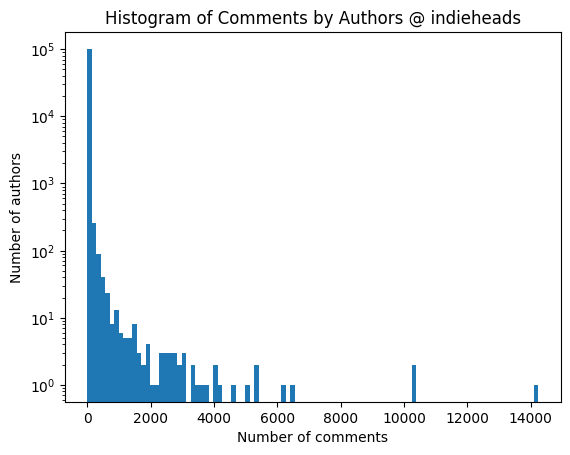

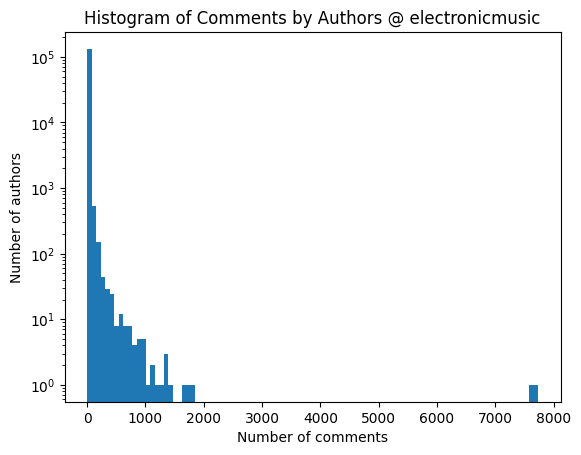

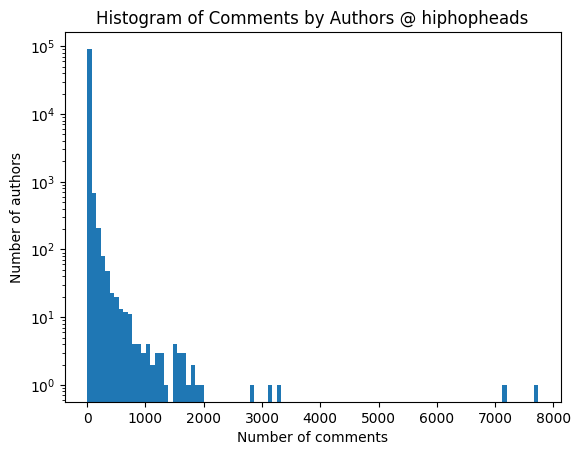

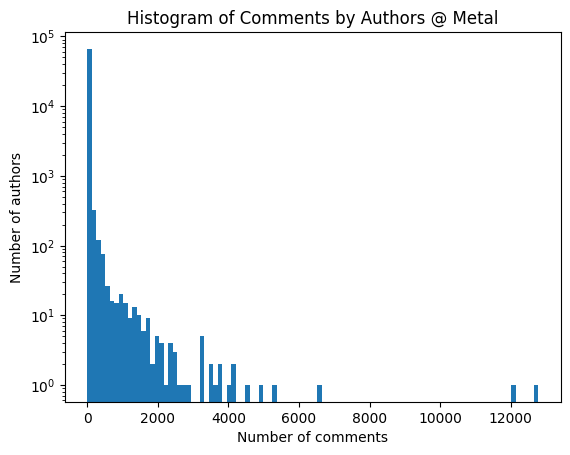

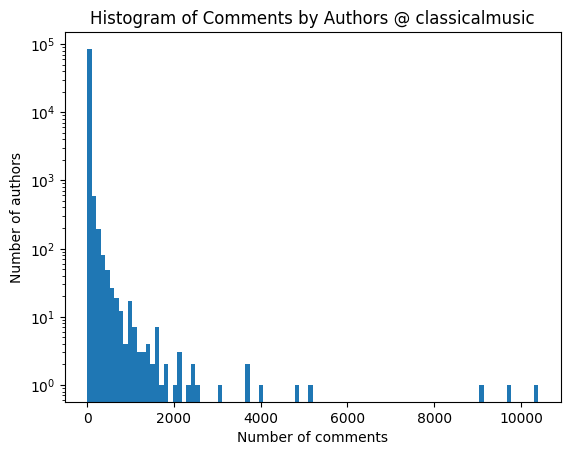

In [16]:
for community_name, community_authors in non_intersection_authors.items():
    values = list(community_authors.values())
    num_bins = 100
    plt.hist(values, bins=num_bins)
    plt.yscale('log')
    plt.xlabel('Number of comments')
    plt.ylabel('Number of authors')
    plt.title(f'Histogram of Comments by Authors @ {community_name}')
    plt.show()

# TOP N Commenters in every community


In [17]:
def get_top_n_commenters(n: int, commenters: dict) -> list:
    sorted_dict = dict(sorted(commenters.items(), key=lambda x: x[1], reverse=True))
    return list(sorted_dict.items())[:n]

top_commenters_by_community = {}
comment_amounts = [500, 1000, 2000]
for community_name, community_authors in non_intersection_authors.items():
    for amount in comment_amounts:
        top_n_commenters = get_top_n_commenters(n=amount, commenters=community_authors)
        print(f"{community_name} | {amount}th commenter --> {top_n_commenters[amount-1]}")
        if amount == 1000:
            top_commenters_by_community[community_name] = [commenter[0] for commenter in top_n_commenters]
    print('----')



indieheads | 500th commenter --> ('johancolli', 143)
indieheads | 1000th commenter --> ('dubrovnique', 78)
indieheads | 2000th commenter --> ('MaunShcAllister', 41)
----
electronicmusic | 500th commenter --> ('Dysphoriography', 111)
electronicmusic | 1000th commenter --> ('God_I_Suck', 70)
electronicmusic | 2000th commenter --> ('kaydpea', 44)
----
hiphopheads | 500th commenter --> ('RyVsWorld', 145)
hiphopheads | 1000th commenter --> ('beerrabbit124', 87)
hiphopheads | 2000th commenter --> ('Killthomas7', 51)
----
Metal | 500th commenter --> ('maximusfpv', 179)
Metal | 1000th commenter --> ('BillyTalentfan', 88)
Metal | 2000th commenter --> ('thrashinbatman', 45)
----
classicalmusic | 500th commenter --> ('felixou98', 191)
classicalmusic | 1000th commenter --> ('throwawayAcc16777216', 109)
classicalmusic | 2000th commenter --> ('TheQueefGoblin', 58)
----


# Commenters that posted more than Y comments in every community


In [18]:
comment_amounts = [50, 200, 500, 1000]
for community_name, community_authors in non_intersection_authors.items():
    for amount in comment_amounts:
        sorted_commenters = sorted(community_authors.items(), key=lambda x: x[1], reverse=True)
        top_list = [commenter for commenter in sorted_commenters if commenter[1] >= amount]
        print(f"{community_name} | Y={amount} --> {len(top_list)} commenters with {amount} or more comments")
    print('----')


indieheads | Y=50 --> 1646 commenters with 50 or more comments
indieheads | Y=200 --> 354 commenters with 200 or more comments
indieheads | Y=500 --> 136 commenters with 500 or more comments
indieheads | Y=1000 --> 69 commenters with 1000 or more comments
----
electronicmusic | Y=50 --> 1642 commenters with 50 or more comments
electronicmusic | Y=200 --> 194 commenters with 200 or more comments
electronicmusic | Y=500 --> 60 commenters with 500 or more comments
electronicmusic | Y=1000 --> 15 commenters with 1000 or more comments
----
hiphopheads | Y=50 --> 2059 commenters with 50 or more comments
hiphopheads | Y=200 --> 319 commenters with 200 or more comments
hiphopheads | Y=500 --> 90 commenters with 500 or more comments
hiphopheads | Y=1000 --> 35 commenters with 1000 or more comments
----
Metal | Y=50 --> 1799 commenters with 50 or more comments
Metal | Y=200 --> 468 commenters with 200 or more comments
Metal | Y=500 --> 186 commenters with 500 or more comments
Metal | Y=1000 --> 

# Focus on top 1000 in every community

We'll track all of their activity accross all reddit, without their musical community activity.


In [19]:
for community in top_commenters_by_community:
    print(community)
    print(top_commenters_by_community[community])

indieheads
['PaulaAbdulJabar', 'InSearchOfGoodPun', 'chug-a-lug-donna', 'Tadevos', 'mqr53', 'CentreToWave', 'MIArular', 'idontreallycare4', 'Srtviper', 'systemofstrings', 'a_gallon_of_pcp', 'MCK_OH', 'scottmakingcents', 'SecondSkin', 'NRuxin12', 'plzaskmeaboutloom', 'RegalWombat', 'indieheads-ModTeam', 'freav', 'roseisonlineagain', 'ssgtgriggs', 'chkessle', 'finelytunedsounds', '-porm', 'seaofblasphemy', 'LoneBell', 'toadeh690', 'ScCloudy', 'Nessfull', 'BertMacklinMD', 'p-u-n-k_girl', 'pallum', 'VietRooster', 'Whatsanillinois', 'ItsJoshy', 'NevenSuboticFanNo1', 'Finger_My_Chord', 'Mark_Zuckerberg420', 'qazz23', '5centraise', 'maa13', 'boldsprite', 'NFLfreak98', 'stansymash', 'god_is_ender', 'big_blue520', 'esperadok', 'hefightabear', 'stayhoided', 'ColorCoatDrawing', 'bboy037', 'WoweeZoweePavyWavy', 'TheMummyDetective', 'JayElecHanukkah', 'FightYaAtThePrody', 'KaiserFill', 'Staplingdean', 'lastfollower', 'sarcasticsobs', 'not_a_skunk', 'HighestIQInFresno', 'Eldritch-field-ditch', 'Bate

In [22]:
def write_or_append_to_json_file(data_dict, file_path):
    file_size = 0
    if os.path.isfile(file_path):
        file_size = os.stat(file_path).st_size

    with open(file_path, 'ab') as fp:
        if file_size > 0:
            fp.seek(file_size - 2)  # Move the file pointer to the last character
            fp.truncate()  # Remove the last character
            fp.write(b',')  # Add a comma to separate the JSON objects
        fp.write(json.dumps(data_dict).encode('utf-8'))  # Write the new JSON data

    fp.close()


In [ ]:
from http.client import FORBIDDEN
import praw
import datetime
from collections import defaultdict
import json
from tqdm import tqdm
from prawcore.exceptions import NotFound, Forbidden
from retry import retry

reddit = praw.Reddit(
    client_id='w7tYilptWAf8X_bSFgw1ew',
    client_secret='SFLZmwK6Lcqj86s-WH98Sh3L4kwm4w',
    user_agent='desktop:eliranse-musical-preferences:v1.0.0 (by /u/eliranse)',
)

# reddit = praw.Reddit(
#     client_id='1LxqtJft3LM75yx2MgPqAA',
#     client_secret='W8roMmNh_uBIFaJj4LzMgoTOWN8fow',
#     user_agent='desktop:eliranse-musical-preferences-oauth:v1.0.0 (by /u/eliranse)',
#     username='eliranse',
#     password='SGK.3Bwb9a!6i!2'
# )


@retry((Forbidden, Exception), delay=2, tries=3)
def fetch_user_activity(username):
    current_date = datetime.datetime.utcnow()
    one_year_ago = current_date - datetime.timedelta(days=900)
    subreddit_data = defaultdict(lambda: {"count": 0, "submissions": [], "comments": []})
    for submission in paginate_results(reddit.redditor(username).submissions.new, limit=None):
        if submission.created_utc < one_year_ago.timestamp():
            break
        subreddit_name = submission.subreddit.display_name
        subreddit_data[subreddit_name]["count"] += 1
        subreddit_data[subreddit_name]["submissions"].append({
            "title": submission.title,
            "body": submission.selftext,
            "domain": submission.domain,
            "date": submission.created_utc
        })

    for comment in paginate_results(reddit.redditor(username).comments.new, limit=None):
        if comment.created_utc < one_year_ago.timestamp():
            break
        subreddit_name = comment.subreddit.display_name
        subreddit_data[subreddit_name]["count"] += 1
        subreddit_data[subreddit_name]["comments"].append({
            "body": comment.body,
            "date": datetime.datetime.fromtimestamp(comment.created_utc).isoformat()
        })
    return subreddit_data

def paginate_results(fetch_function, limit=None):
    results = []
    last_item = None

    while True:
        if last_item is None:
            new_results = list(fetch_function(limit=limit))
        else:
            new_results = list(fetch_function(limit=limit, params={'after': last_item}))
        if not new_results:
            break
        results.extend(new_results)
        last_item = new_results[-1].name
    return results

already_done = ['Metal', 'electronicmusic', 'indieheads', 'hiphopheads']
for community in top_commenters_by_community:
    if community in already_done:
        continue
    print(f"Community: {community}")
    for username in tqdm(top_commenters_by_community[community]):
        try:
            user_activity = fetch_user_activity(username)
        except Exception:
            user_activity = {}
        write_or_append_to_json_file(user_activity, f"/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/classicalmusic/{username}.json")


In [39]:
import os
import json

def count_empty_json_files(folder_path):
    empty_count = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and file_path.endswith('.json'):
            with open(file_path, 'r') as file:
                try:
                    data = json.load(file)
                    if not data:
                        empty_count += 1
                except json.JSONDecodeError:
                    print(f"Error loading JSON from file: {file_path}")
    return empty_count

for community_name in ['Metal', 'electronicmusic', 'indieheads', 'hiphopheads', 'classicalmusic']:
    folder_path = f'/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data/{community_name}'
    empty_files_count = count_empty_json_files(folder_path)
    print(f"Missing members of {community_name}: {empty_files_count}. Left with: {1000-empty_files_count}")




Missing members of Metal: 285. Left with: 715
Missing members of electronicmusic: 338. Left with: 662
Missing members of indieheads: 134. Left with: 866
Missing members of hiphopheads: 167. Left with: 833
Missing members of classicalmusic: 252. Left with: 748


In [3]:
import os
import json
import csv

# Define the path to the main folder containing the genre folders
main_folder_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data'

# Define the header row for the CSV file
header = ['musical_genre_community', 'username', 'subreddit 1 name', 'subreddit 1 count',
          'subreddit 2 name', 'subreddit 2 count', 'subreddit 3 name', 'subreddit 3 count',
          'subreddit 4 name', 'subreddit 4 count', 'subreddit 5 name', 'subreddit 5 count',
          'subreddit 6 name', 'subreddit 6 count', 'subreddit 7 name', 'subreddit 7 count',
          'subreddit 8 name', 'subreddit 8 count', 'subreddit 9 name', 'subreddit 9 count',
          'subreddit 10 name', 'subreddit 10 count']

# Create a list to store the data rows for the CSV file
data_rows = []

# Iterate over the genre folders
for genre_folder in os.listdir(main_folder_path):
    genre_folder_path = os.path.join(main_folder_path, genre_folder)
    
    # Skip any files or directories starting with a dot
    if genre_folder.startswith('.'):
        continue
    
    # Iterate over the JSON files in the genre folder
    for filename in os.listdir(genre_folder_path):
        file_path = os.path.join(genre_folder_path, filename)
        
        # Skip any files or directories starting with a dot
        if filename.startswith('.'):
            continue
        
        # Extract the username from the filename
        username = os.path.splitext(filename)[0]
        
        # Read the JSON file
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)
        
        # Skip empty JSON files
        if not json_data:
            continue
        
        # Extract the subreddit data from the JSON
        subreddit_data = json_data.keys()
        
        # Exclude the current musical genre from the top subreddits
        subreddit_data = [subreddit for subreddit in subreddit_data if subreddit != genre_folder]
        
        sorted_subreddits = sorted(subreddit_data, key=lambda x: json_data[x]['count'], reverse=True)
        top_subreddits = sorted_subreddits[:10]
        
        # Create a list for the current row's data
        row = [genre_folder, username]
        
        # Append the subreddit names and counts to the row
        for subreddit in top_subreddits:
            row.append(subreddit)
            row.append(json_data[subreddit]['count'])
        
        # Add the row to the data_rows list
        data_rows.append(row)

# Write the data to a CSV file
csv_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/output.csv'
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write the header row
    writer.writerow(header)
    
    # Write the data rows
    writer.writerows(data_rows)


In [ ]:
import os
import json

# Define the path to the main folder containing the genre folders
main_folder_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data'

# Iterate over the genre folders
for genre_folder in os.listdir(main_folder_path):
    genre_folder_path = os.path.join(main_folder_path, genre_folder)

    # Skip any files or directories starting with a dot
    if genre_folder.startswith('.'):
        continue

    # Create a dictionary to store subreddit counts
    subreddit_counts = {}

    # Iterate over the JSON files in the genre folder
    for filename in os.listdir(genre_folder_path):
        file_path = os.path.join(genre_folder_path, filename)

        # Skip any files or directories starting with a dot
        if filename.startswith('.'):
            continue

        # Read the JSON file
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)

        # Extract the subreddit data from the JSON
        subreddit_data = json_data.keys()

        # Exclude the current musical genre from the top subreddits
        subreddit_data = [subreddit for subreddit in subreddit_data if subreddit != genre_folder]

        # Update the subreddit counts
        for subreddit in subreddit_data:
            count = json_data[subreddit]['count']
            if count >= 1:
                subreddit_counts[subreddit] = subreddit_counts.get(subreddit, 0) + 1

    # Sort the subreddit counts in descending order
    sorted_counts = sorted(subreddit_counts.items(), key=lambda x: x[1], reverse=True)

    # Print the summary for the current musical genre
    print("Musical Genre: ", genre_folder)
    for subreddit, count in sorted_counts:
        print("Subreddit: ", subreddit)
        print("Number of Users: ", count)
        print("---")
    print("==========")


In [15]:
import os
import json
import pandas as pd
from openpyxl import Workbook

# Define the path to the main folder containing the genre folders
main_folder_path = '/Users/eliran.shemtov/DevProjects/Musical-Preferences/Musical-Preferences-And-Textual-Expression/new_detailed_data'

# Create a dictionary to store the subreddit data for each community
community_data = {}

# Iterate over the genre folders
for genre_folder in os.listdir(main_folder_path):
    genre_folder_path = os.path.join(main_folder_path, genre_folder)

    # Skip any files or directories starting with a dot
    if genre_folder.startswith('.'):
        continue

    # Create a dictionary to store subreddit counts for the current community
    subreddit_counts = {}

    # Iterate over the JSON files in the genre folder
    for filename in os.listdir(genre_folder_path):
        file_path = os.path.join(genre_folder_path, filename)

        # Skip any files or directories starting with a dot
        if filename.startswith('.'):
            continue

        # Read the JSON file
        with open(file_path, 'r') as json_file:
            json_data = json.load(json_file)

        # Extract the subreddit data from the JSON
        subreddit_data = json_data.keys()

        # Exclude the current musical genre from the top subreddits
        subreddit_data = [subreddit for subreddit in subreddit_data if subreddit != genre_folder]

        # Update the subreddit counts
        for subreddit in subreddit_data:
            count = json_data[subreddit]['count']
            if count >= 1:
                subreddit_counts[subreddit] = subreddit_counts.get(subreddit, 0) + 1

    # Sort the subreddit counts in descending order
    sorted_counts = sorted(subreddit_counts.items(), key=lambda x: x[1], reverse=True)

    # Store the subreddit counts for the current community in the dictionary
    community_data[genre_folder] = sorted_counts

# Create a Workbook object
workbook = Workbook()

# Iterate over the community data and save each community in a separate sheet
for community, subreddit_counts in community_data.items():
    # Create a DataFrame from the subreddit counts
    df = pd.DataFrame(subreddit_counts, columns=['Subreddit', 'Number of Users'])

    # Create a new sheet with the community name
    sheet = workbook.create_sheet(title=community)

    # Write the column titles to the sheet
    sheet.append(['Subreddit', 'Number of Users'])

    # Write the data to the sheet
    for row in df.itertuples(index=False):
        sheet.append(row)

# Remove the default sheet created by the Workbook
workbook.remove(workbook['Sheet'])

# Save the Excel file
workbook.save('community_summary.xlsx')


Top subreddits - the number is the count of users that commented or posted at least once in a subreddit


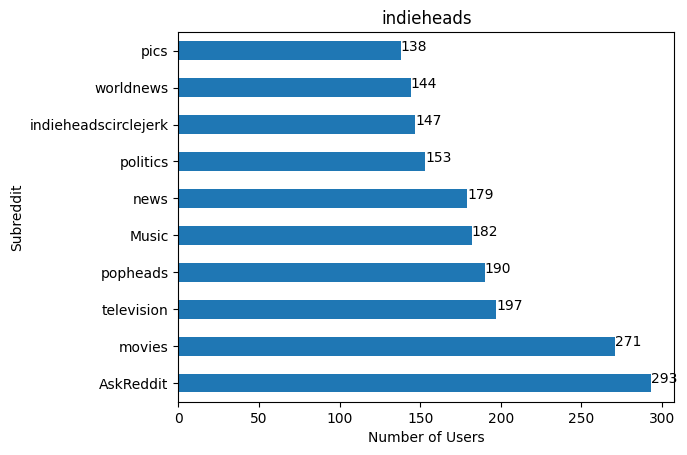

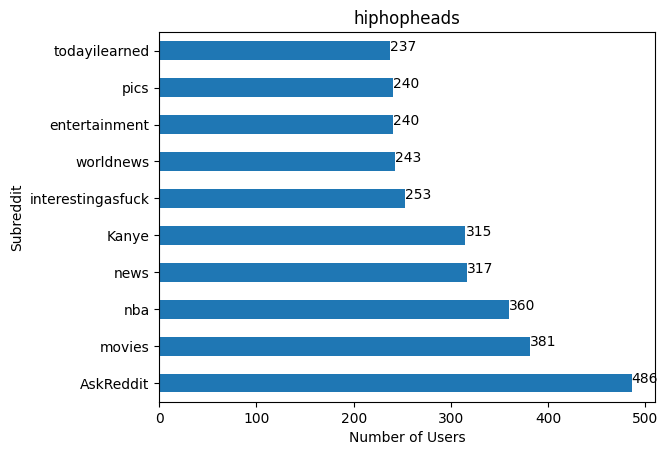

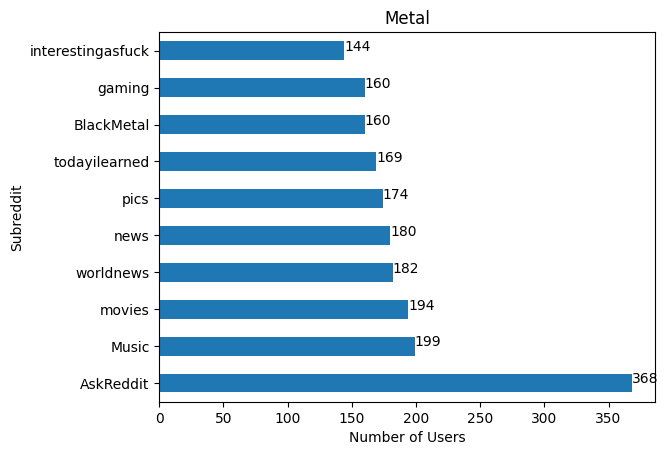

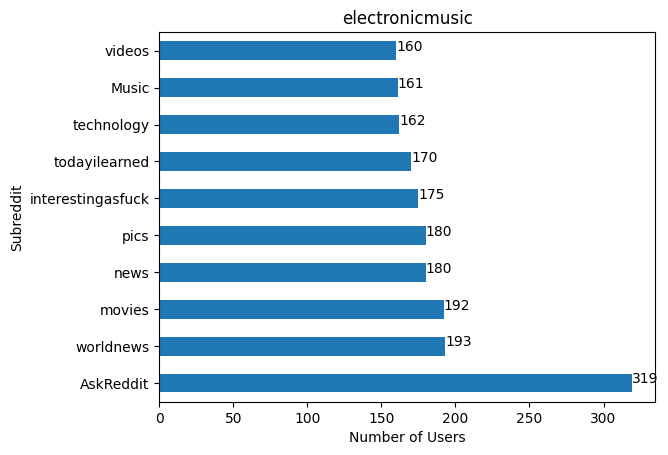

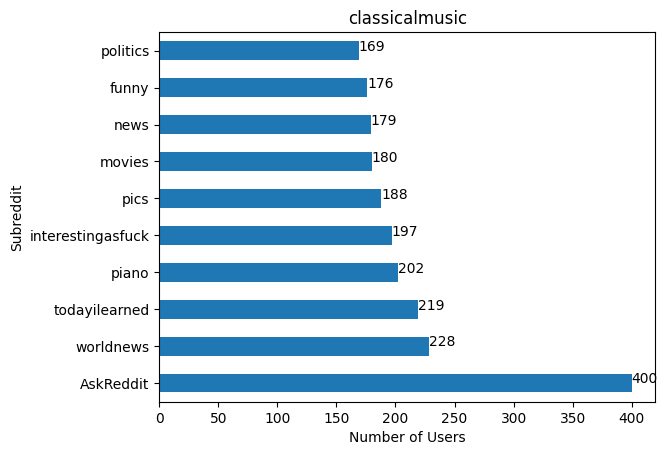

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

print('Top subreddits - the number is the count of users that commented or posted at least once in a subreddit')
# Load the community data from the saved Excel file
xlsx_file = 'community_summary.xlsx'
xl = pd.ExcelFile(xlsx_file)

# Set the maximum number of subreddits to plot
max_subreddits = 10

# Iterate over each sheet (community) in the Excel file
for sheet_name in xl.sheet_names:
    # Read the data from the sheet into a DataFrame
    df = xl.parse(sheet_name)

    # Sort the DataFrame by the number of users in descending order
    df.sort_values(by='Number of Users', ascending=False, inplace=True)

    # Select the top N subreddits
    top_subreddits = df.head(max_subreddits)

    # Set the subreddit names and numbers of users as the index for easier plotting
    top_subreddits.set_index('Subreddit', inplace=True)

    # Create a horizontal bar plot
    ax = top_subreddits.plot(kind='barh', legend=False)
    ax.set_xlabel('Number of Users')
    ax.set_ylabel('Subreddit')

    # Set the title of the plot to the community name
    ax.set_title(sheet_name)

    # Add labels with the number of users to each bar
    for i, value in enumerate(top_subreddits['Number of Users']):
        ax.text(value, i, str(value))

    # Show the plot
    plt.show()


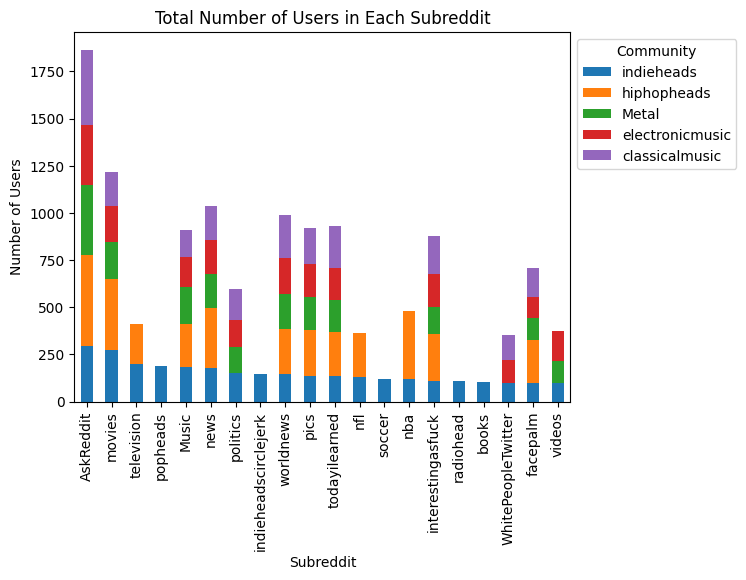

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the community data from the saved Excel file
xlsx_file = 'community_summary.xlsx'
xl = pd.ExcelFile(xlsx_file)

# Set the maximum number of subreddits to plot
max_subreddits = 20

# Create an empty DataFrame to store the data for the stacked bar chart
data = pd.DataFrame()

# Iterate over each sheet (community) in the Excel file
for sheet_name in xl.sheet_names:
    # Read the data from the sheet into a DataFrame
    df = xl.parse(sheet_name)

    # Sort the DataFrame by the number of users in descending order
    df.sort_values(by='Number of Users', ascending=False, inplace=True)

    # Select the top N subreddits
    top_subreddits = df.head(max_subreddits)

    # Set the subreddit names and numbers of users as columns in the data DataFrame
    data[sheet_name] = top_subreddits.set_index('Subreddit')['Number of Users']

# Plot the stacked bar chart
ax = data.plot(kind='bar', stacked=True)
ax.set_xlabel('Subreddit')
ax.set_ylabel('Number of Users')
ax.set_title('Total Number of Users in Each Subreddit')

# Show the legend
ax.legend(title='Community', bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.show()
